# Performance Comparison: vindex vs. fast_vindex

In [1]:
import dask
import fast_vindex

In [2]:
print(dask.__version__)
print(fast_vindex.__version__)

2025.9.1
0.0.3


In [3]:
import time

import dask.array as da
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress

from fast_vindex import patched_vindex
from fast_vindex.testing import generate_fancy_indexes

In [4]:
shape = (5_000, 5_000, 5_000)
chunks = (500, 500, 500)
x = da.random.random(shape, chunks=chunks) 
x 

dask.array<random_sample, shape=(5000, 5000, 5000), dtype=float64, chunksize=(500, 500, 500), chunktype=numpy.ndarray>

In [5]:
N = 19
n_obs = n_obs = [2**i for i in range(N)]
padding = 10
methods = ['vindex', 'fast_vindex']

In [6]:
%%time
data = []
for method in methods:
    for n in n_obs:
        print(method, n)
        indexes = generate_fancy_indexes(x, n=n, padding=padding)
        
        if method == 'fast_vindex':
            start = time.time()
            with patched_vindex():
                x.vindex[indexes]
            end = time.time()
            data.append(dict(n=n, method=method, padding=padding, run_time=end-start))
        else:
            if n > 8192:
                pass
            else:
                start = time.time()
                x.vindex[indexes]
                end = time.time()
                data.append(dict(n=n, method=method, padding=padding, run_time=end-start))
        

vindex 1
vindex 2
vindex 4
vindex 8
vindex 16
vindex 32
vindex 64
vindex 128
vindex 256
vindex 512
vindex 1024
vindex 2048
vindex 4096
vindex 8192
vindex 16384
vindex 32768
vindex 65536
vindex 131072
vindex 262144
fast_vindex 1
fast_vindex 2
fast_vindex 4
fast_vindex 8
fast_vindex 16
fast_vindex 32
fast_vindex 64
fast_vindex 128
fast_vindex 256
fast_vindex 512
fast_vindex 1024
fast_vindex 2048
fast_vindex 4096
fast_vindex 8192
fast_vindex 16384
fast_vindex 32768
fast_vindex 65536
fast_vindex 131072
fast_vindex 262144
CPU times: user 1min 19s, sys: 6.77 s, total: 1min 26s
Wall time: 1min 25s


In [7]:
df = pd.DataFrame(data)
df = df.groupby(['n', 'method', 'padding'])['run_time'].describe()[['50%']].reset_index()

In [8]:
df.head()

,n,method,padding,50%
0,1,fast_vindex,10,0.001008
1,1,vindex,10,0.003781
2,2,fast_vindex,10,0.000786
3,2,vindex,10,0.005516
4,4,fast_vindex,10,0.000900


In [9]:
def plot(filename, log=True, save=False):
    plt.figure(figsize=(10, 6))
    colors = {'vindex': "#50e991", 'fast_vindex': "#0bb4ff"}
    versions = {'vindex': dask.__version__, 'fast_vindex': fast_vindex.__version__}
    slopes = {}
    for idx, method in enumerate(methods):
        label = f"{method} ({versions[method]})"
        values = df[df['method'] == method].sort_values(by='n')
        x_val = values['n']
        y_val = values['50%']
        slope_y, intercept_y, r_value, p_value, std_err = linregress(x_val, y_val)
        slopes[method] = slope_y
        print(f"Slope y: {slope_y}")
        plt.plot(x_val, y_val, marker='o', linestyle='-', color=colors[method], label=label)
    plt.title('Performance Comparison: vindex vs. fast_vindex')
    plt.xlabel('Number of Observations')
    plt.ylabel('Runtime [s]')
    if log is True:
        plt.xscale('log', base=2)
    plt.legend()
    plt.grid(True)
    if save is True:
        plt.savefig(f'../_static/{filename}.png', format='png', dpi=300)
        print(f"save under : ../_static/{filename}.png")
    plt.show()
    return slopes

Slope y: 0.0028004400193294074
Slope y: 7.588501631301112e-05


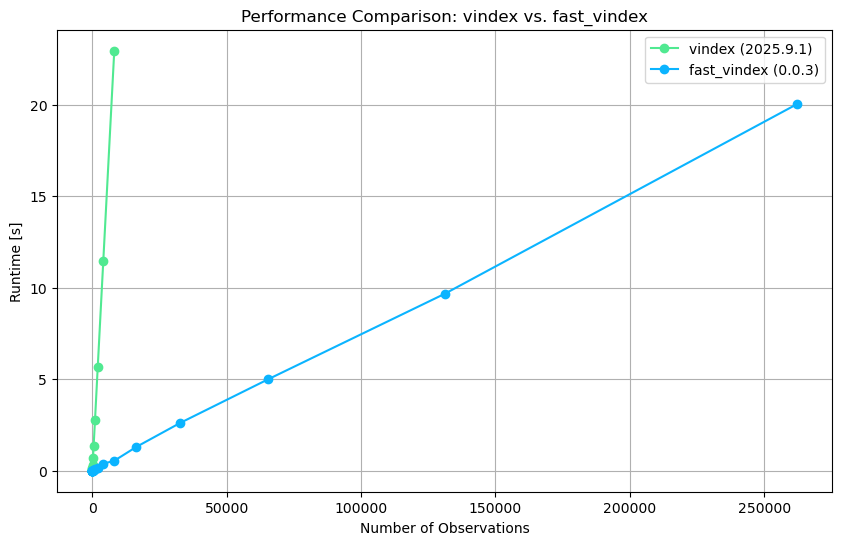

In [10]:
slopes = plot('performance_comparison_vindex_vs_fast_vindex_nolog', log=False, save=False)

Slope y: 0.0028004400193294074
Slope y: 7.588501631301112e-05
save under : ../_static/performance_comparison_vindex_vs_fast_vindex.png


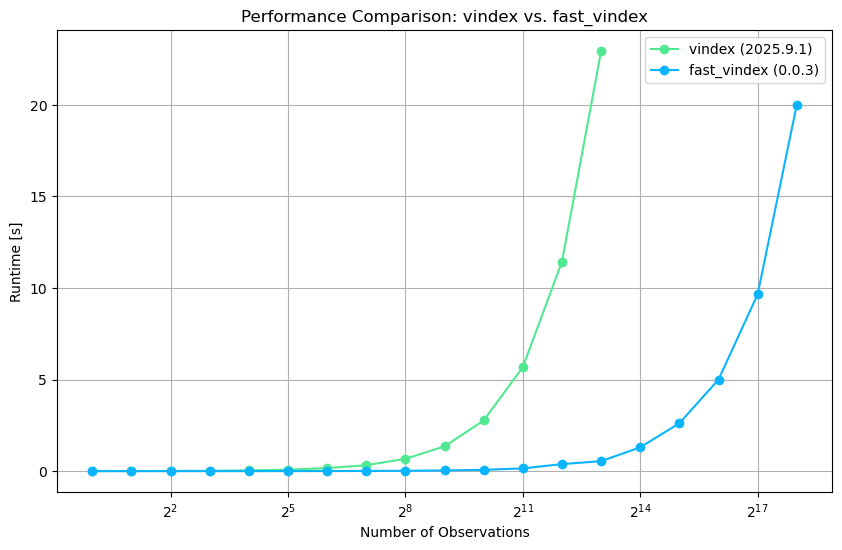

In [11]:
slopes = plot('performance_comparison_vindex_vs_fast_vindex', log=True, save=True)

On calcul ensuite le coefficient 

In [12]:
slopes

{'vindex': np.float64(0.0028004400193294074),
 'fast_vindex': np.float64(7.588501631301112e-05)}

In [13]:
slopes['vindex'] / slopes['fast_vindex']

np.float64(36.90372823770809)